<h1> <b>LSTM을 이용한 잔여수명 예측</b></h1>
&nbsp;

- <h3> <b>데이터 : <a href="https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/">[Turbofan Engine Degradation Simulation Data Set]</a></b></h3>

     - <h4> <b>train data : Run-to-Failure data</b> </h4>
     - <h4> <b>test data : Censored data</b> </h4>
&nbsp;

- <h4> Reference : https://www.kaggle.com/code/mikenguyen1712/nasa-turbofan-predict-rul-using-lstm-and-ar-model</h4>

In [703]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [267]:
trainData =  pd.read_csv("E:\\데이터\\예지보전\\CMAPSSData\\train_FD001.txt", sep=" ",header=None)
testData = pd.read_csv("E:\\데이터\\예지보전\\CMAPSSData\\test_FD001.txt", sep=" ",header=None)

In [268]:
trainData.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [269]:
trainData.drop(columns=[26,27],inplace=True)
testData.drop(columns=[26,27],inplace=True)
trainData.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [270]:
columns = ["Section-{}".format(i)  for i in range(26)]
trainData.columns = columns
testData.columns = columns
trainData.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [272]:
trainData.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [308]:
# 분산이 0인 변수 및 불필요 변수 제거
train = trainData.drop(trainData.columns[[1,4,5,9,10,14,20,22,23]], axis=1)
test = testData.drop(testData.columns[[1,4,5,9,10,14,20,22,23]], axis=1)

In [309]:
train.head()

,Section-0,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [310]:
test.head()

,Section-0,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [313]:
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = trainData[MachineID_name]
RUL_data = trainData[RUL_name]
OS_data = trainData[OS_name]
Sensor_data = trainData[Sensor_name]

In [314]:
# Data in pandas Series
MachineID_series = trainData["Section-0"]
RUL_series = trainData["Section-1"]

In [315]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


In [316]:
gen = MinMaxScaler(feature_range=(0, 1))
train = gen.fit_transform(train)
train = pd.DataFrame(train)
train=np.nan_to_num(train)

pt = PowerTransformer()
train = pt.fit_transform(train)
train

array([[-1.73793847, -0.31975365, -1.3916867 , ..., -0.76399955,
         1.42665355,  1.24248381],
       [-1.73793847,  0.87202066, -1.03174892, ..., -0.76399955,
         1.03734696,  1.29226848],
       [-1.73793847, -1.9503069 ,  1.01385485, ..., -2.35059786,
         0.72414823,  0.465476  ],
       ...,
       [ 1.65062464,  0.18308976,  0.01311911, ...,  2.66650739,
        -1.90974435, -2.75272539],
       [ 1.65062464, -0.50209065,  1.01385485, ...,  1.14636389,
        -2.49938469, -1.91568423],
       [ 1.65062464, -1.45465135, -1.75831429, ...,  1.68933126,
        -2.19492018, -1.99819889]])

In [318]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col
RUL_df()

,rul
0,192
1,191
2,190
3,189
4,188
...,...
20626,5
20627,4
20628,3
20629,2


In [319]:
X_train = np.array(train)
y_train = np.array(RUL_df()).reshape(-1,1)

In [320]:
#print(max_cycles)
print(sum(max_cycles))
count = 0
for cycle_len in max_cycles:
    for i in range(6):
        y_train[count+i] = 0
    count = count + cycle_len
print(count)

20631
20631


In [321]:
def create_dataset(X, AR=10):
    data = []
    for i in range(len(X)-AR-1):
        data.append(X[i:(i+AR)])
    return np.array(data)


X_train = create_dataset(X_train)
y_train = y_train[11:]
X_train.shape # (nrow, timestep, ncol)

(20620, 10, 17)

<h3><b>LSTM 모델링</b></h3>

In [285]:
def predict_model(layers):
        #d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        #model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        #model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mean_squared_error',optimizer='adam')
        return model

In [286]:
model = predict_model([17,10]) # (ncol, timesteps)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 128)           74752     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 125,217
Trainable params: 125,217
Non-trainable params: 0
_________________________________________________________________
None


In [287]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=100,
    validation_split=0.15,
    verbose=1)

Epoch 1/100
35/35 [==============================] - 5s 52ms/step - loss: 14753.6787 - val_loss: 17913.2617
Epoch 2/100
35/35 [==============================] - 1s 41ms/step - loss: 14291.6299 - val_loss: 17113.9375
Epoch 3/100
35/35 [==============================] - 1s 43ms/step - loss: 13339.9600 - val_loss: 15819.6543
Epoch 4/100
35/35 [==============================] - 1s 42ms/step - loss: 11974.4004 - val_loss: 14136.8652
Epoch 5/100
35/35 [==============================] - 2s 43ms/step - loss: 10345.3496 - val_loss: 12274.0176
Epoch 6/100
35/35 [==============================] - 1s 42ms/step - loss: 8676.7568 - val_loss: 10463.2861
Epoch 7/100
35/35 [==============================] - 2s 43ms/step - loss: 7179.5098 - val_loss: 8912.4189
Epoch 8/100
35/35 [==============================] - 1s 40ms/step - loss: 6016.7393 - val_loss: 7753.8262
Epoch 9/100
35/35 [==============================] - 1s 41ms/step - loss: 5237.7061 - val_loss: 6990.7544
Epoch 10/100
35/35 [===============

35/35 [==============================] - 1s 38ms/step - loss: 45.3448 - val_loss: 3059.1021
Epoch 79/100
35/35 [==============================] - 1s 40ms/step - loss: 41.8187 - val_loss: 3130.4888
Epoch 80/100
35/35 [==============================] - 1s 39ms/step - loss: 41.5865 - val_loss: 3182.4285
Epoch 81/100
35/35 [==============================] - 1s 38ms/step - loss: 39.8707 - val_loss: 3166.8076
Epoch 82/100
35/35 [==============================] - 1s 40ms/step - loss: 38.7633 - val_loss: 3105.5256
Epoch 83/100
35/35 [==============================] - 1s 38ms/step - loss: 36.8004 - val_loss: 3093.6421
Epoch 84/100
35/35 [==============================] - 1s 41ms/step - loss: 35.1083 - val_loss: 3132.7446
Epoch 85/100
35/35 [==============================] - 1s 39ms/step - loss: 33.5170 - val_loss: 3163.8169
Epoch 86/100
35/35 [==============================] - 1s 40ms/step - loss: 32.5957 - val_loss: 3107.2434
Epoch 87/100
35/35 [==============================] - 1s 40ms/step -

In [322]:
y_train_pred = model.predict(X_train)
print("R-Squared Score ", r2_score(y_train,y_train_pred))

R-Squared Score  0.8956246743206494


In [323]:
testRUL = pd.read_csv("E:\\데이터\\예지보전\\CMAPSSData\\RUL_FD001.txt", names=['rul'])
testRUL.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [291]:
RUL_name = ["Section-1"]
RUL_data = testData[RUL_name]
MachineID_series = testData["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

In [329]:
gen = MinMaxScaler(feature_range=(0, 1))
test = gen.fit_transform(test)
test = pd.DataFrame(test)
pt = PowerTransformer()
test = pt.fit_transform(test)
test=np.nan_to_num(test)
# test = test[:,1:]

In [334]:
X_test = np.array(test)
y_test = np.array(testRUL)

print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 135 341 155 258 283 336 202 156 185 200]


In [336]:
def create_dataset(X, look_back=10):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)
X_test = create_dataset(X_test)
print(X_test.shape,y_test.shape)

(13085, 10, 17) (100, 1)


In [337]:
pred = model.predict(X_test)

In [385]:
# test data Machine Id 별 current time
ct = []
for machineID in range(100) :
    ct.append(sum(testData['Section-0']==machineID+1))

print(ct)

[31, 49, 126, 106, 98, 105, 160, 166, 55, 192, 83, 217, 195, 46, 76, 113, 165, 133, 135, 184, 148, 39, 130, 186, 48, 76, 140, 158, 171, 143, 196, 145, 50, 203, 198, 126, 121, 125, 37, 133, 123, 156, 172, 54, 152, 146, 73, 78, 303, 74, 144, 189, 164, 121, 113, 136, 160, 176, 94, 147, 159, 232, 155, 168, 71, 147, 71, 187, 54, 152, 68, 131, 112, 137, 88, 205, 162, 72, 101, 133, 213, 162, 73, 172, 34, 110, 56, 68, 177, 146, 234, 150, 244, 133, 89, 97, 134, 121, 97, 198]


In [612]:
# Machine ID 별 RUL
initial = pred[0:ct[0]]
predMat = [initial]
for i in range(99):
    predMat.append(pred[np.cumsum(ct)[i]:np.cumsum(ct)[i+1]])

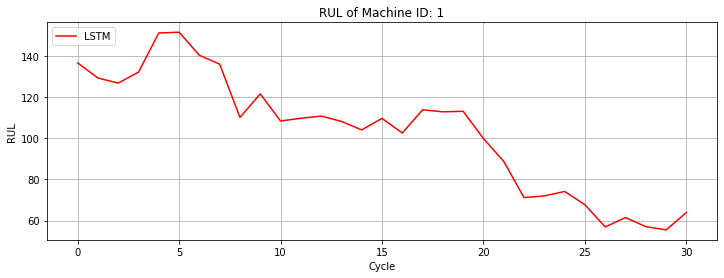

In [697]:
machineID = 1
fig = plt.figure(figsize=(12,4))
plt.plot(predMat[machineID-1],color='red', label='LSTM')
plt.title("RUL of Machine ID: " + str(machineID))
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [642]:
# 전체 시점의 평균 RUL
meanRUL = []
for machineID in range(100):
    meanRUL.append(np.mean(predMat[machineID]))

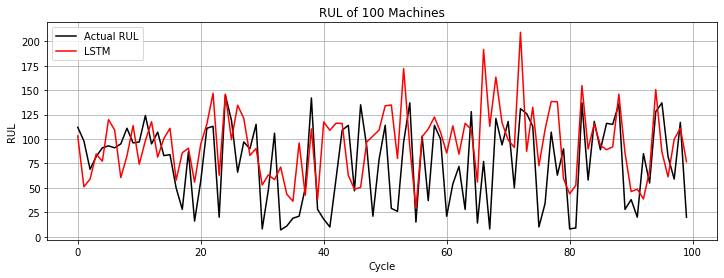

In [645]:
# RUL
fig = plt.figure(figsize=(12,4))
plt.plot(testRUL['rul'], color='black', label='Actual RUL')
plt.plot(meanRUL, color='red', label='LSTM')
plt.title("RUL of 100 Machines")
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [694]:
# testEoL
testEoL = testRUL['rul'] + ct
LSTMEoL = []
for machineID in range(100):
    EoL = ct[machineID]+meanRUL[machineID]
    LSTMEoL.append(EoL)

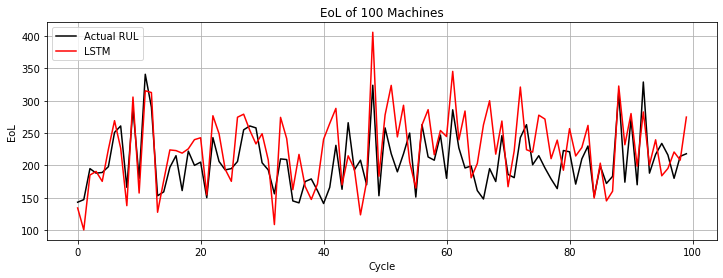

In [696]:
# EoL
fig = plt.figure(figsize=(12,4))
plt.plot(testEoL, color='black', label='Actual RUL')
plt.plot(LSTMEoL, color='red', label='LSTM')
plt.title("EoL of 100 Machines")
plt.xlabel('Cycle')
plt.ylabel('EoL')
plt.legend(loc='upper left')
plt.grid()
plt.show()